In [1]:
import pandas as pd
import numpy as np
from utils import get_text

In [2]:
def is_institution(p):
    institutions = ["bệnh viện", "viện", "khoa", "học viện", "đại học", "trung tâm"]
    institution_flag = False
    for institution in institutions:
        if institution in p.lower():
            institution_flag = True
            break
    
    return institution_flag

def is_title(p):
    titles = ["bác sĩ", "bs", "ts", "thầy thuốc", "pgs", "gs", "tiến sĩ", 
        "lương y", "chuyên gia", "thạc sĩ", "chuyên viên"]
    title_flag = False
    for title in titles:
        if title in p[:35].lower():
            title_flag = True
            break
    
    return title_flag

is_short = lambda p: len(p.split("\n")[0]) < 50
is_not_long = lambda p: len(p.split("\n")[0]) < 200

def is_name(p):
    names = ['đoàn', 'võ', 'đinh', 'lục', 'bùi', 'trần', 'hồ', 'lưu', 'chu', 'dương',
        'vũ', 'ngô', 'trương', 'huỳnh', 'phùng', 'lê', 'lương', 'đỗ', 'hoàng', 
        'đặng', 'phan', 'văn', 'phạm', 'thị', 'kim', 'lý', 'nguyễn', 'tạ',
        'nguyên', 'thái', 'cao', 'trịnh', 'mai', 'tô', 'hà', 'châu', 'hương',
        'duy', 'trà', 'ngữ', 'sơn', 'yến', 'hải', 'paul', 'kiều', 'andrew']
    name_flag = False
    list_p = p.lower().replace(',', '').split()
    for name in names:
        if name in list_p[:12]:
            name_flag = True
            break
    
    return name_flag

In [3]:
def aggregate(df_path, main_question_col, desc_question_col, answer_col, link_col, link_href_col):
    df = pd.read_excel(df_path)
    df[main_question_col] = df[[
        main_question_col, link_col]
        ].bfill(axis=1).iloc[:,0]
    df_agg = df.fillna('NA').groupby(link_href_col).agg({
        main_question_col: lambda x: x.tolist()[0],
        desc_question_col: lambda x: x.tolist()[0],
        answer_col: lambda x: x.tolist(),
        }).reset_index()
    return df_agg.rename(columns={
        link_href_col: 'link',
        main_question_col: 'main_question',
        desc_question_col: 'desc_question',
        answer_col: 'answers'
        })

def preprocess(df_agg):
    list_out = []
    for line in df_agg.to_dict('records'):
        article_link_href = line['link']
        main_question_text = line['main_question']
        desc_question_text = line['desc_question']
        answer_text = line['answers']
        if 'Trả lời:' not in answer_text:
            continue
        else:
            # if "Bị chó cắn sau bao lâu" in main_question_text:
            #     import pdb; pdb.set_trace()
            is_answer = False
            is_source = False
            desc_question_list_out = []
            answer_list_out = []
            source_list_out = []
            for p in [desc_question_text] + answer_text:
                if p == 'Trả lời:':
                    is_answer = True
                elif is_title(p) and is_name(p) and (is_short(p) or \
                    (is_institution(p[:70]) and is_not_long(p))):
                    is_source = True
                    source_list_out.append(p)
                elif not is_answer:
                    desc_question_list_out.append(p)
                elif is_answer and not is_source:
                    answer_list_out.append(p)
                elif is_source:
                    source_list_out.append(p)
            if ')' in desc_question_list_out[-1][-5:]:
                desc_question_list_out[-1] = '('.join(desc_question_list_out[-1].split('(')[:-1])
            desc_question_text_out = '\n'.join(desc_question_list_out).strip()
            if len(answer_list_out) == 0:
                continue
            else:
                if answer_list_out[-1]=='NA' or 'tại đây' in answer_list_out[-1].lower() or 'độc giả' in answer_list_out[-1].lower():
                    answer_list_out.pop()
                if len(answer_list_out) == 0:
                    continue

                if len(source_list_out) > 0 and (source_list_out[-1]=='NA' or 'tại đây' in source_list_out[-1].lower() or 'độc giả' in source_list_out[-1].lower()):
                    source_list_out.pop()
                
            if is_title(answer_list_out[-1]):
                answer_text_out = '\n'.join(answer_list_out[:-1])
            else:
                answer_text_out = '\n'.join(answer_list_out)
            source = '\n'.join(source_list_out)
            list_out.append([article_link_href, main_question_text, desc_question_text_out, answer_text_out, source])
    
    df_out = pd.DataFrame(list_out, columns=['link', 'main_question', 'desc_question', 'answers', 'source'])

    return df_out


In [4]:
df_clean = preprocess(aggregate(
    'data/health_v0.xlsx',
    'main-question-text',
    'desc-question-text',
    'answer-text',
    'article-link',
    'article-link-href'))
print(df_clean.shape)

(338, 5)


In [5]:
df_clean_v2 = preprocess(aggregate(
    'data/health_v1.xlsx',
    'main_question',
    'desc_question',
    'answers',
    'article-links',
    'article-links-href'))
print(df_clean_v2.shape)

(338, 5)


In [6]:
df_clean_v3 = preprocess(aggregate(
    'data/health-nutrition.xlsx',
    'main_question',
    'desc_question',
    'answers',
    'article-links',
    'article-links-href'))
print(df_clean_v3.shape)

(45, 5)


In [7]:
df_clean_v4 = preprocess(aggregate(
    'data/health-disease.xlsx',
    'main_question',
    'desc_question',
    'answers',
    'article-links',
    'article-links-href'))
print(df_clean_v4.shape)

(416, 5)


In [8]:
# Combine the dataframes and remove duplicates
df_clean_final = pd.concat([df_clean, df_clean_v2, df_clean_v3, df_clean_v4]).drop_duplicates(subset=['link']).reset_index(drop=True)

In [9]:
df_clean_final.drop(columns=['link'], inplace=True)
df_clean_final.head()

,main_question,desc_question,answers,source
0,Ăn bánh mì chấm sữa buổi sáng có tốt?,Gia đình tôi thường xuyên ăn bánh mì chấm sữa ...,Bánh mì chấm sữa buổi sáng được nhiều người lự...,"Tiến sĩ, bác sĩ Nguyễn Trọng Hưng\nViện Dinh d..."
1,Ăn bao nhiêu miếng bánh chưng thì không béo?,"Tôi rất thích ăn đồ nếp, đặc biệt là bánh chưn...",Bánh chưng là món ăn có lịch sử lâu đời và gắn...,TS.BS. Trương Hồng Sơn\nViện trưởng Viện Y học...
2,Ăn cá bụng to hay bé tốt hơn?,"Khi mua cá, tôi thường chọn những con bụng to ...",Mỗi loại cá có thành phần dinh dưỡng khác nhau...,PGS.TS Nguyễn Duy Thịnh\nViện Công nghệ sinh h...
3,Ăn cá hay thịt tốt hơn?,Nhiều người cho rằng nên ăn nhiều cá thay vì t...,Cá và thịt đều là nguồn protein chính và quan ...,PGS. TS Nguyễn Duy Thịnh\nViện Khoa học và Côn...
4,Ăn cà muối xổi có gây độc?,"Gia đình tôi hay ăn cà muối xổi, song nhiều th...","Cà pháo có tác dụng kích thích đường ruột, dễ ...",PGS Nguyễn Duy Thịnh\nViện Công nghệ sinh học ...


In [10]:
df_clean_final[df_clean_final['main_question'].apply(lambda x: 'bị chó cắn' in x.lower())]

,main_question,desc_question,answers,source
66,Bị chó cắn sau bao lâu cần tiêm vaccine phòng ...,Chỗ tôi sống có rất nhiều chó thả rông nên tôi...,Nếu chẳng may bị động vật cào/cắn hoặc liếm lê...,"ThS.BS Ngô Thị Kim Phượng\nQuản lý Y khoa, Hệ ..."
319,Vì sao có người bị chó cắn sau nhiều năm mới t...,Tôi đọc báo thấy có trường hợp bị chó dại cắn ...,Dù đã có vaccine phòng ngừa hiệu quả bệnh dại ...,"ThS.BS Ngô Thị Kim Phượng\nQuản lý Y khoa, Hệ ..."


In [11]:
df_clean_final.shape

(746, 4)

In [12]:
df_clean_final[~df_clean_final['source'].apply(is_title)]

,main_question,desc_question,answers,source
192,Khó nuốt có phải triệu chứng của ung thư?,"Hai tuần nay tôi khó nuốt, cảm giác vướng ở cổ...",Khó nuốt có thể là triệu chứng của bệnh ung th...,
203,Làm sao khi trẻ mắc hội chứng sợ kim tiêm?,Cứ mỗi lần nhắc đến chuyện tiêm phòng hoặc nhì...,"Theo Hiệp hội Tâm thần Mỹ, hội chứng sợ kim ti...",
308,"Uống nước lá, hoa đu đủ có trị được ung thư?",Nhiều người mách uống nước sắc lá và hoa đu đủ...,"Quả đu đủ nhiều giá trị dinh dưỡng, nhiều vita...",
331,Vỏ trái cây và rau củ có tốt cho sức khỏe?,Tôi có thói quen không gọt vỏ một số loại trái...,Vỏ trái cây hoặc rau củ thường bị loại bỏ do s...,


In [13]:
print(df_clean_final[~df_clean_final['source'].apply(is_title)].iloc[1]['answers'])

Theo Hiệp hội Tâm thần Mỹ, hội chứng sợ kim tiêm cũng được xếp vào nhóm rối loạn lo âu, một dạng rối loạn tâm thần thường gặp. Đây là cơ chế nhằm bảo vệ cơ thể khỏi bị tổn hại, có thể phát triển thành chứng rối loạn tâm thần suy nhược.
Các dấu hiệu bao gồm: Nhịp tim và huyết áp tăng đột ngột khi nhìn thấy kim tiêm; hoặc giảm nhịp tim gây giảm huyết áp; ngất xỉu; lo lắng tột độ không giải thích được; hoảng loạn khi thấy kim tiêm... Ở trẻ em, bé có thể khóc, nổi cơn thịnh nộ, lạnh cóng và bám víu vào người lớn. Nỗi sợ có thể tiến triển thành các cơn hoảng loạn, mất ngủ và né tránh đi khám bác sĩ kể cả khi trẻ lớn lên.
Sợ tiêm là tình trạng thường gặp ở trẻ nhỏ, bạn có thể giúp các bé vượt qua nỗi sợ này bằng nhiều cách như dưới đây.
Không nói dối trẻ
Ba mẹ nên giải thích với con về lợi ích của việc tiêm ngừa vaccine, không nên nói dối trẻ. Cần báo trước khoảng một ngày tiêm để trẻ chuẩn bị tâm lý và thích ứng. Không nên báo việc tiêm ngừa cho trẻ quá sớm vì dễ khiến trẻ căng thẳng, lo sợ

In [14]:
print(df_clean_final.loc[66, 'answers'])

Nếu chẳng may bị động vật cào/cắn hoặc liếm lên vết thương hở, bạn cần tiêm vaccine phòng dại càng sớm càng tốt để cơ thể kịp sinh kháng thể ngăn chặn sự tấn công của virus dại, tốt nhất là ngay trong ngày đầu tiên. Đặc biệt, nếu vết thương nặng hoặc ở các vị trí như đầu, mặt, cổ, đầu các chi, bộ phận sinh dục... thì càng phải tiêm sớm nhất có thể.
Sau khi xâm nhập vào cơ thể người, virus dại nhanh chóng nhân số lượng lên nhiều lần và bắt đầu di chuyển dọc theo các dây thần kinh, tiến thẳng lên não với tốc độ từ 12-24mm mỗi ngày. Một số người chờ đến khi chó, mèo chết mới chịu đi tiêm, như vậy rất nguy hiểm.
Ngoài việc tiêm phòng sau khi bị chó, mèo cắn thì chúng ta cũng có thể tiêm dự phòng trước phơi nhiễm, nghĩa là chủ động tiêm khi chưa bị động vật cắn. Đây là cách để hạn chế rủi ro, bảo vệ an toàn tính mạng cho những người thường xuyên tiếp xúc với động vật, có nguy cơ tiếp xúc với virus dại mà không hay biết.
Về số lượng và thời gian các mũi tiêm sẽ phụ thuộc vào từng phác đồ như

In [15]:
def separate_credit(answers):
    list_lines = answers.split('\n')
    titles = ["bác sĩ", "bs", "ts", "thầy thuốc", "pgs", "gs", "tiến sĩ", "lương y"]
    is_title = False
    for title in titles:
        if title in list_lines[-1].lower():
            is_title = True
            break
    institutions = ["bệnh viện", "viện", "trường", "phòng khám", "phòng mạch",
        "trưởng khoa"]
    is_institution = False
    for institution in institutions:
        if institution in list_lines[-1].lower():
            is_institution = True
            break
    if is_title:
        return '\n'.join(list_lines[:-1]), list_lines[-1] + "\n"
    elif is_institution:
        return '\n'.join(list_lines[:-2]), '\n'.join(list_lines[-2:]) + "\n"
    else:
        return answers, ''

In [16]:
df_clean_final['text'] = df_clean_final.apply(get_text, axis=1)

In [17]:
df_clean_final.shape

(746, 5)

<AxesSubplot: >

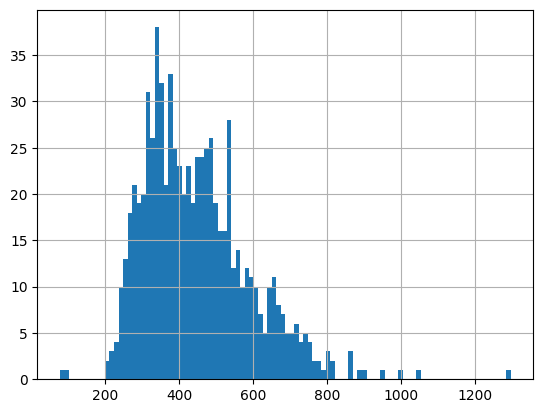

In [18]:
df_clean_final['num_words'] = df_clean_final['text'].apply(lambda x: len(x.split()))
df_clean_final['num_words'].hist(bins=100)

In [19]:
df_out = df_clean_final[
    df_clean_final['num_words'].between(100,800) & df_clean_final['source'].apply(lambda x: len(x) >= 5)
    ].reset_index(drop=True)

In [20]:
# Train-test split 5% test
np.random.seed(42)
df_out['train'] = np.random.uniform(0, 1, len(df_out)) <= .95
df_out['train'].value_counts()


True     688
False     41
Name: train, dtype: int64

In [21]:
df_out[df_out['train']].reset_index(drop=True).to_parquet(
    'data/clean/health_qa_train.parquet')
df_out[~df_out['train']].reset_index(drop=True).to_parquet(
    'data/clean/health_qa_test.parquet')

In [22]:
df_out.to_parquet('data/clean/health_qa.parquet')

In [23]:
df_out.to_excel('data/clean/health_qa.xlsx', index=False)

In [24]:
name_and_title_words = []
for list_text in df_out['source'].apply(lambda x: x.split('\n')[0].split()[:10]):
    for text in list_text:
        name_and_title_words.append(text.lower())